In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.optimize import least_squares

######################## Some Pandas Reminders ####################################
# MyData.head()                             # Peak at first 5 rows of the data
# MyData.x                                  # Data of column called "x"
# MyData.iloc[0,:]                          # First row
# MyData.iloc[:,0]                          # First column
# MyData.columns[0]                         # Name of first column
# MyData['Seconds'] = 3600 * MyData.Hours   # Create a new column named as such and caluclated as such
# MyData[MyData > 0]                        # Return Data Frame with conditional

In [2]:
'''Describe the experiment'''
'''
pL2f1513 is pBAD-RBS30-GFP, pLacI-RBS30-AraC* (P080-U015-SC035, P017-U015-SC047)
pL2f1517 is pLas-RBS30-GFP, pLacI-RBS30-AraC*, pBAD-RBS30-lasR (P007-U015-SC035, P017-U015-SC047, P080-U015-SC012)
pL2f1518 is pLas-RBS30-GFP, pLacI-RBS30-AraC*, pBAD-RBS30-lasR (P030-U015-SC035, P017-U015-SC047, P080-U015-SC012)
pL2f1519 is pLux-RBS30-GFP, pLacI-RBS30-AraC*, pBAD-RBS30-luxR (P050-U015-SC035, P017-U015-SC047, P080-U015-SC015)
pL2f1525 is pLux!las-RBS32-GFP, pLacI-RBS30-AraC*, pBAD-RBS30-luxR  (P078-U017-SC035, P017-U015-SC047, P080-U015-SC015)
'''
print()

In [3]:
'''Define some user functions'''
def activation_hill(x, maximal, Kd, n):
    '''https://en.wikipedia.org/wiki/Hill_equation_(biochemistry)'''
    return maximal * (x**n / (Kd**n + x**n))

def represion_hill(x, maximal, Kd, n):
    '''https://en.wikipedia.org/wiki/Hill_equation_(biochemistry)'''
    return maximal * (1 / (x / Kd)**n)

def report_parameters(fitted_parameter_names, fitted_parameter_values):
    for each in range(len(fitted_parameter_names)):
        print(fitted_parameter_names[each], 'is', np.round(fitted_parameter_values[each], 3))
hill_function_parameter_names = ['Basal', 'Max', 'Kd', 'n'] 

custom_consistent_yaxis = [5,10**6] # We want all the graphs to have the same scale y-axis for this analysis

loss = 0.00443383612441
       # in units of min**-1

In [4]:
def pL2f1513_model(arabinose, *parameters):
    expression = activation_hill(arabinose, *parameters[1:4]) + parameters[0] # basal
                 # in units of MEFL / min**-1
   
    return (expression / loss)
    
def inducible_activation_model(TF, SM, *parameters):
    '''
    parameters:
    basal basal
    basal max
    basal Kd
    basal n

    SM-TF Kd
    SM-TF n 
    
    TF*SM - Promoter max
    TF*SM - Promoter Kd
    TF*SM - Promoter n
    '''
 
    TF_bound = activation_hill(SM, TF, *parameters[4:6])
    TF_unbound = TF - TF_bound
    # in units of MEFL
    
    basal = parameters[0] + activation_hill(TF_unbound, *parameters[1:4])
    # in units of MEFL / min**-1
    
    induced_promoters = activation_hill(TF_bound, *parameters[6:9])
    # in units of MEFL / min**-1
    
    expression =  basal + induced_promoters
    # in units of MEFL / min**-1
    
    GFP = expression / loss
    return GFP # in units of MEFL

Basal is 0.217
Max is 553.026
Kd is 679.361
n is 1.987


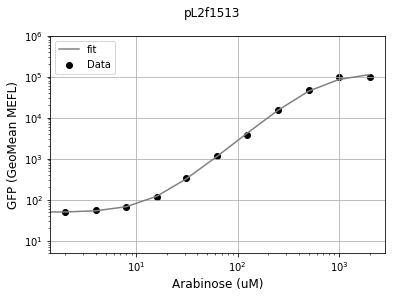

In [5]:
'''    pL2f1513 is pBAD-RBS30-GFP, pLacI-RBS30-AraC*    '''
pL2f1513_data = pd.read_excel('pL2f1513.xlsx') # GFP is in GeoMean MEFL

def pL2f1513_error_function(current_parameter_guess):
    '''We log transform the guess and ground truth to remove large number bias'''
    current_parameter_guess = tuple(current_parameter_guess)
    y_guess = pL2f1513_model(pL2f1513_data.arabinose_uM, *current_parameter_guess)
    error = np.log10(y_guess) - np.log10(pL2f1513_data.GFP)
    return error

initial_guess = (100, 100, 100, 2)
lower_bounds = [0, 0, 0, 0]
upper_bounds = [1000000, 1000000, 1000000, 10]
pL2f1513_fitted_parameters = least_squares(pL2f1513_error_function,
                                           initial_guess, 
                                           bounds=(lower_bounds, upper_bounds)
                                           ).x
report_parameters(hill_function_parameter_names, pL2f1513_fitted_parameters)

plt.scatter(pL2f1513_data.arabinose_uM, pL2f1513_data.GFP, c='k', label='Data')
plt.plot(pL2f1513_data.arabinose_uM, 
         pL2f1513_model(pL2f1513_data.arabinose_uM, *pL2f1513_fitted_parameters), 
         c='grey', label = 'fit')

plt.suptitle('pL2f1513')
plt.legend(loc = 'upper left')

plt.xlabel('Arabinose (uM)', fontsize=12)
plt.xscale('log')
#plt.xlim(1,2100)

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1513 - GFP vs Arabinose.png', transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

In [6]:
'''pL2f1517'''
print()

In [7]:
pL2f1517_data = pd.read_excel('pL2f1517.xlsx')
pL2f1517_data['TF_MEFL'] = pL2f1513_model(pL2f1517_data.arabinose_uM, *pL2f1513_fitted_parameters)
pL2f1517_data.head()

,arabinose_uM,lasAHL_nM,GFP,TF_MEFL
0,0.0,0.0,200.501363,48.878376
1,2.0,0.0,192.935178,50.044426
2,4.0,0.0,200.589226,53.500617
3,8.0,0.0,196.707332,67.199509
4,16.0,0.0,201.573412,121.474057


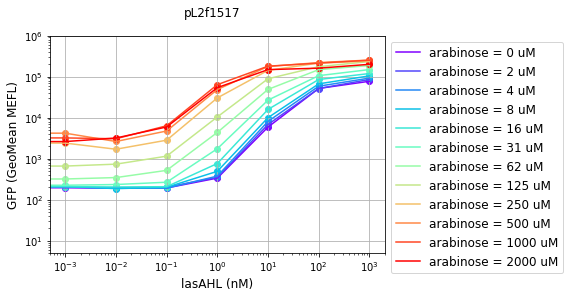

In [8]:
# Let's plot GFP as a function of AHL, for constant arabinose

num_plots = len(pL2f1517_data.arabinose_uM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1517_data.arabinose_uM.unique():
    m = pL2f1517_data[pL2f1517_data.arabinose_uM == each]
    plt.plot(m.lasAHL_nM, m.GFP, label = 'arabinose = ' + str(int(np.round(each))) + ' uM')
    plt.scatter(m.lasAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1517')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('lasAHL (nM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1517 - GFP vs lasAHL - constant arabinose.png',
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

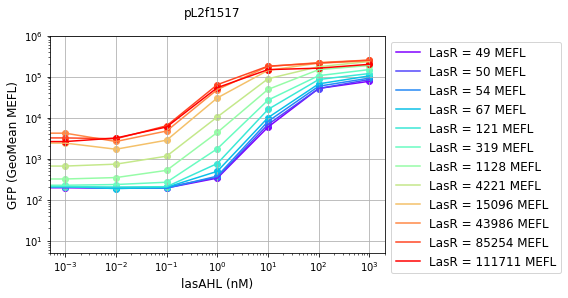

In [9]:
# Let's plot GFP as a function of AHL, for constant transcription factor

num_plots = len(pL2f1517_data.TF_MEFL.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1517_data.TF_MEFL.unique():
    m = pL2f1517_data[pL2f1517_data.TF_MEFL == each]
    plt.plot(m.lasAHL_nM, m.GFP, label = 'LasR = ' + str(int(np.round(each))) + ' MEFL')
    plt.scatter(m.lasAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1517')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('lasAHL (nM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1517 - GFP vs lasAHL - constant LasR.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

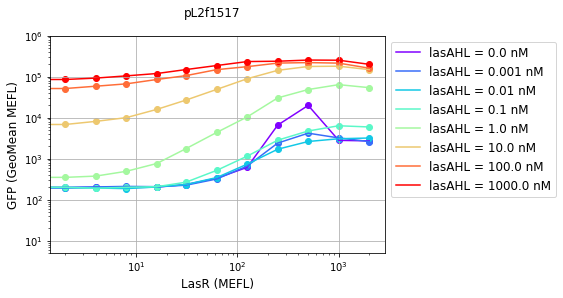

In [10]:
# Let's plot GFP as a function of transcription factor, for constant AHL

num_plots = len(pL2f1517_data.lasAHL_nM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1517_data.lasAHL_nM.unique():
    m = pL2f1517_data[pL2f1517_data.lasAHL_nM == each]
    plt.plot(m.arabinose_uM, m.GFP, label = 'lasAHL = ' + str(each) + ' nM')
    plt.scatter(m.arabinose_uM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1517')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('LasR (MEFL)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1517 - GFP vs LasR - constant lasAHL.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

In [11]:
def pL2f1517_error_function(current_parameter_guess):
    '''We log transform the guess and ground truth to remove large number bias'''
    current_parameter_guess = tuple(current_parameter_guess)
    y_guess = inducible_activation_model(pL2f1517_data.TF_MEFL, pL2f1517_data.lasAHL_nM, *current_parameter_guess)
    error = np.log10(y_guess) - np.log10(pL2f1517_data.GFP)
    return error

initial_guess = (1, 1, 1, 1, 1, 1, 1, 1, 1)
low_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0]
up_bounds = [100000, 100000, 100000, 10, 100000, 10, 100000, 100000, 10]
pL2f1517_parameters = least_squares(pL2f1517_error_function,
                                    initial_guess, 
                                    bounds=(low_bounds, up_bounds)
                                    ).x
print(pL2f1517_parameters)

[  8.80809684e-01   1.56531967e+01   1.01993374e+04   1.71885728e+00
   7.59762782e+01   1.83137522e+00   8.95850096e+02   9.28182299e+01
   7.76443122e-01]


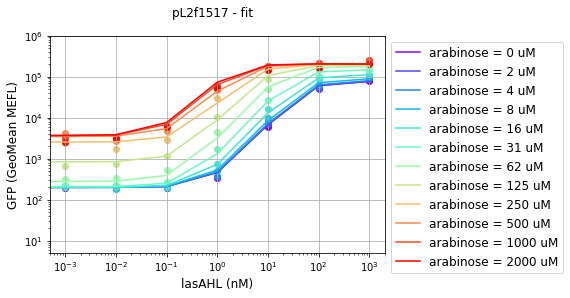

In [12]:
# Let's plot the fit, with GFP as a function of AHL, with constant arabinose

num_plots = len(pL2f1517_data.arabinose_uM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1517_data.arabinose_uM.unique():
    m = pL2f1517_data[pL2f1517_data.arabinose_uM == each]
    plt.plot(m.lasAHL_nM, inducible_activation_model(m.TF_MEFL, m.lasAHL_nM, *pL2f1517_parameters), 
             label = 'arabinose = ' + str(int(np.round(each))) + ' uM')
    plt.scatter(m.lasAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1517 - fit')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('lasAHL (nM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1517 - GFP vs lasAHL - constant arabinose - fit.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

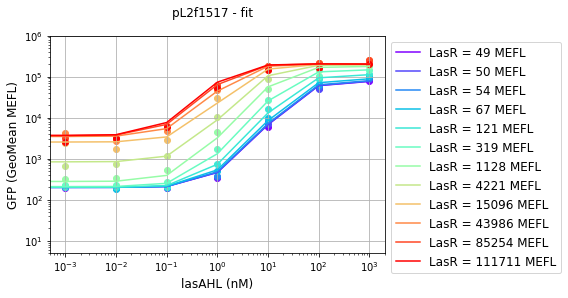

In [13]:
# Let's plot the fit, with GFP as a function of AHL, with constant LasR

num_plots = len(pL2f1517_data.TF_MEFL.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1517_data.TF_MEFL.unique():
    m = pL2f1517_data[pL2f1517_data.TF_MEFL == each]
    plt.plot(m.lasAHL_nM, inducible_activation_model(m.TF_MEFL, m.lasAHL_nM, *pL2f1517_parameters), 
             label = 'LasR = ' + str(int(round(each))) + ' MEFL')
    plt.scatter(m.lasAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1517 - fit')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('lasAHL (nM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1517 - GFP vs lasAHL - constant TF - fit.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

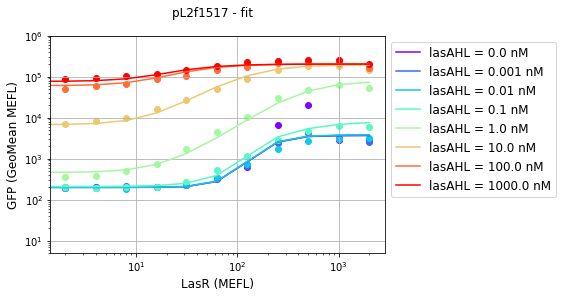

In [14]:
# Let's plot the fit, with GFP as a function of LasR, with constant lasAHL

num_plots = len(pL2f1517_data.lasAHL_nM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1517_data.lasAHL_nM.unique():
    m = pL2f1517_data[pL2f1517_data.lasAHL_nM == each]
    plt.plot(m.arabinose_uM, inducible_activation_model(m.TF_MEFL, m.lasAHL_nM, *pL2f1517_parameters),
             label = 'lasAHL = ' + str(each) + ' nM')
    plt.scatter(m.arabinose_uM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1517 - fit')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('LasR (MEFL)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1517 - GFP vs LasR - constant lasAHL - fit.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

In [15]:
'''pL2f1518'''
print()

In [16]:
pL2f1518_data = pd.read_excel('pL2f1518.xlsx')
pL2f1518_data['TF_MEFL'] = pL2f1513_model(pL2f1517_data.arabinose_uM, *pL2f1513_fitted_parameters)
pL2f1518_data.head()

,arabinose_uM,lasAHL_nM,GFP,TF_MEFL
0,0.0,0.0,100.886810,48.878376
1,2.0,0.0,110.689785,50.044426
2,4.0,0.0,103.986262,53.500617
3,8.0,0.0,109.049552,67.199509
4,16.0,0.0,103.242263,121.474057


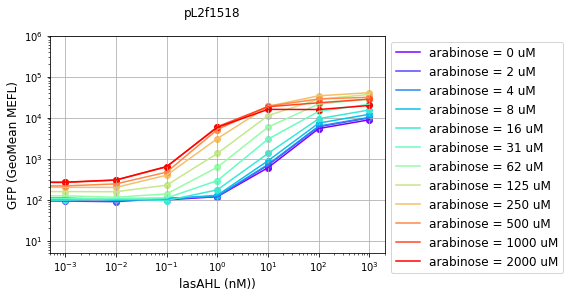

In [17]:
# Let's plot the raw data as a function of AHL, for constant arabinose

num_plots = len(pL2f1518_data.arabinose_uM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1518_data.arabinose_uM.unique():
    m = pL2f1518_data[pL2f1518_data.arabinose_uM == each]
    plt.plot(m.lasAHL_nM, m.GFP, label = 'arabinose = ' + str(int(np.round(each))) + ' uM')
    plt.scatter(m.lasAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1518')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('lasAHL (nM))', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1518 - GFP vs lasAHL - constant arabinose.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

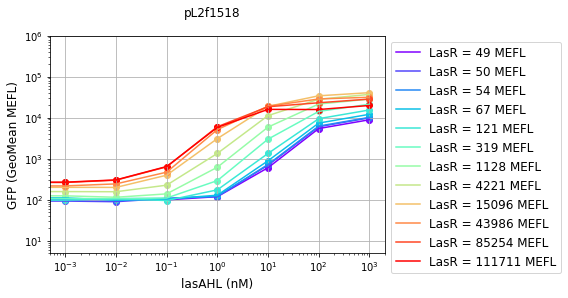

In [18]:
# Let's plot the raw data as a function of AHL, for constant transcription factor

num_plots = len(pL2f1518_data.TF_MEFL.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1518_data.TF_MEFL.unique():
    m = pL2f1518_data[pL2f1518_data.TF_MEFL == each]
    plt.plot(m.lasAHL_nM, m.GFP, label = 'LasR = ' + str(int(np.round(each))) + ' MEFL')
    plt.scatter(m.lasAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1518')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('lasAHL (nM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1518 - GFP vs lasAHL - constant LasR.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

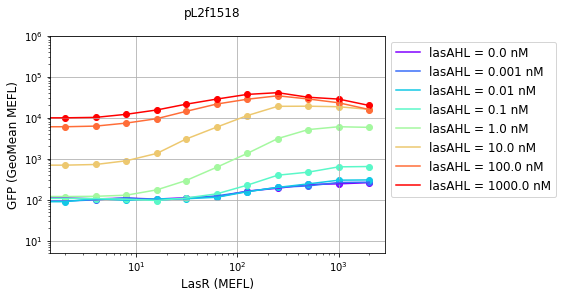

In [19]:
# Let's plot the raw data as a function of transcription factor, for constant AHL

num_plots = len(pL2f1518_data.lasAHL_nM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1518_data.lasAHL_nM.unique():
    m = pL2f1518_data[pL2f1518_data.lasAHL_nM == each]
    plt.plot(m.arabinose_uM, m.GFP, label = 'lasAHL = ' + str(each) + ' nM')
    plt.scatter(m.arabinose_uM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1518')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('LasR (MEFL)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1518 - GFP vs LasR - constant lasAHL.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

In [20]:
def pL2f1518_error_function(current_parameter_guess):
    '''We log transform the guess and ground truth to remove large number bias'''
    current_parameter_guess = tuple(current_parameter_guess)
    y_guess = inducible_activation_model(pL2f1518_data.TF_MEFL, pL2f1518_data.lasAHL_nM, *current_parameter_guess)
    error = np.log10(y_guess) - np.log10(pL2f1518_data.GFP)
    return error

initial_guess = (1, 1, 1, 1, 1, 1, 1, 1, 1)
low_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0]
up_bounds = [100000, 100000, 100000, 10, 100000, 10, 100000, 100000, 10]
pL2f1518_parameters = least_squares(pL2f1518_error_function,
                                    initial_guess, 
                                    bounds=(low_bounds, up_bounds)
                                    ).x
print(pL2f1518_parameters)

[  4.24896427e-01   7.91365713e-01   9.68728118e+03   7.90786849e-01
   1.27060929e+02   1.70896690e+00   1.20367964e+02   1.04428299e+02
   7.33802666e-01]


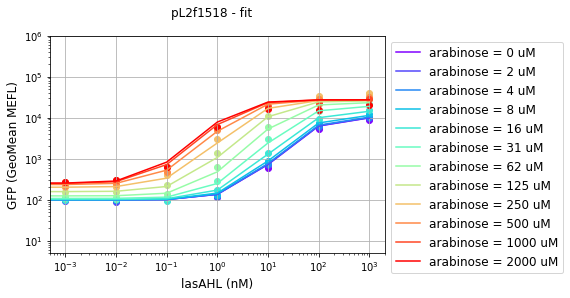

In [21]:
# Let's plot the fit, with GFP as a function of lasAHL, with constant arabinose

num_plots = len(pL2f1518_data.arabinose_uM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1518_data.arabinose_uM.unique():
    m = pL2f1518_data[pL2f1518_data.arabinose_uM == each]
    plt.plot(m.lasAHL_nM, inducible_activation_model(m.TF_MEFL, m.lasAHL_nM, *pL2f1518_parameters), 
             label = 'arabinose = ' + str(int(np.round(each))) + ' uM')
    plt.scatter(m.lasAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1518 - fit')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('lasAHL (nM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1518 - GFP vs lasAHL - constant arabinose - fit.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

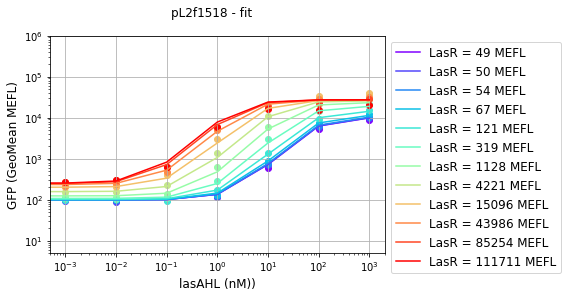

In [22]:
# Let's plot the fit, with GFP as a function of lasAHL, with constant LasR

num_plots = len(pL2f1518_data.TF_MEFL.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1518_data.TF_MEFL.unique():
    m = pL2f1518_data[pL2f1518_data.TF_MEFL == each]
    plt.plot(m.lasAHL_nM, inducible_activation_model(m.TF_MEFL, m.lasAHL_nM, *pL2f1518_parameters), 
             label = 'LasR = ' + str(int(round(each))) + ' MEFL')
    plt.scatter(m.lasAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1518 - fit')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('lasAHL (nM))', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1518 - GFP vs lasAHL - constant lasR - fit.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

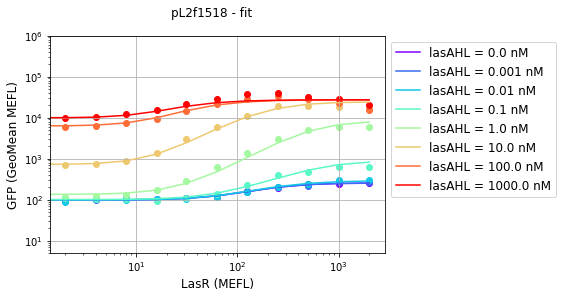

In [23]:
# Let's plot the fit, with GFP as a function of LasR, with constant lasAHL

num_plots = len(pL2f1518_data.lasAHL_nM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1518_data.lasAHL_nM.unique():
    m = pL2f1518_data[pL2f1518_data.lasAHL_nM == each]
    plt.plot(m.arabinose_uM, inducible_activation_model(m.TF_MEFL, m.lasAHL_nM, *pL2f1518_parameters),
             label = 'lasAHL = ' + str(each) + ' nM')
    plt.scatter(m.arabinose_uM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1518 - fit')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('LasR (MEFL)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1518 - GFP vs LasR - constant lasAHL - fit.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

In [24]:
'''pL2f1519'''
print()

In [25]:
pL2f1519_data = pd.read_excel('pL2f1519.xlsx')
pL2f1519_data['TF_MEFL'] = pL2f1513_model(pL2f1517_data.arabinose_uM, *pL2f1513_fitted_parameters)
pL2f1519_data.head()

,arabinose_uM,luxAHL_nM,GFP,TF_MEFL
0,0.0,0.0,421.344878,48.878376
1,2.0,0.0,412.329204,50.044426
2,4.0,0.0,429.298619,53.500617
3,8.0,0.0,423.167389,67.199509
4,16.0,0.0,413.687138,121.474057


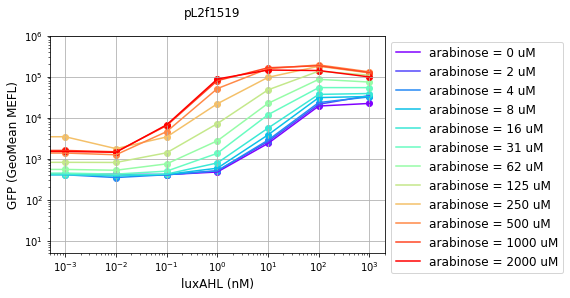

In [26]:
# Let's plot the raw data as a function of AHL, for constant arabinose

num_plots = len(pL2f1519_data.arabinose_uM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1519_data.arabinose_uM.unique():
    m = pL2f1519_data[pL2f1519_data.arabinose_uM == each]
    plt.plot(m.luxAHL_nM, m.GFP, label = 'arabinose = ' + str(int(np.round(each))) + ' uM')
    plt.scatter(m.luxAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1519')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('luxAHL (nM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1519 - GFP vs luxAHL - constant arabinose.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

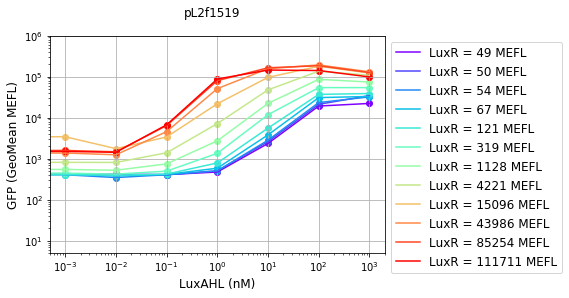

In [27]:
# Let's plot the raw data as a function of AHL, for constant transcription factor

num_plots = len(pL2f1519_data.TF_MEFL.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1519_data.TF_MEFL.unique():
    m = pL2f1519_data[pL2f1519_data.TF_MEFL == each]
    plt.plot(m.luxAHL_nM, m.GFP, label = 'LuxR = ' + str(int(np.round(each))) + ' MEFL')
    plt.scatter(m.luxAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1519')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('LuxAHL (nM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1519 - GFP vs luxAHL - constant LuxR.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

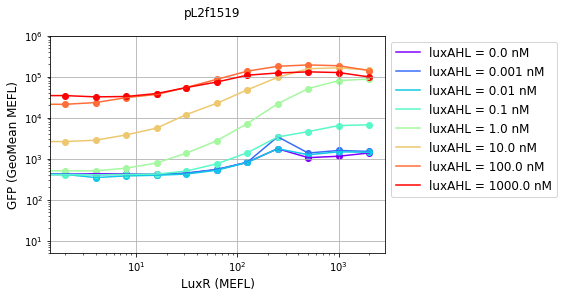

In [28]:
# Let's plot the raw data as a function of transcription factor, for constant AHL

num_plots = len(pL2f1519_data.luxAHL_nM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1519_data.luxAHL_nM.unique():
    m = pL2f1519_data[pL2f1519_data.luxAHL_nM == each]
    plt.plot(m.arabinose_uM, m.GFP, label = 'luxAHL = ' + str(each) + ' nM')
    plt.scatter(m.arabinose_uM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1519')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('LuxR (MEFL)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1519 - GFP vs LuxR - constant luxAHL.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

In [29]:
def pL2f1519_error_function(current_parameter_guess):
    '''We log transform the guess and ground truth to remove large number bias'''
    current_parameter_guess = tuple(current_parameter_guess)
    y_guess = inducible_activation_model(pL2f1519_data.TF_MEFL, pL2f1519_data.luxAHL_nM, *current_parameter_guess)
    error = np.log10(y_guess) - np.log10(pL2f1519_data.GFP)
    return error

initial_guess = (1, 1, 1, 1, 1, 1, 1, 1, 1)
low_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0]
up_bounds = [100000, 100000, 100000, 10, 100000, 10, 100000, 100000, 10]
pL2f1519_parameters = least_squares(pL2f1519_error_function,
                                    initial_guess, 
                                    bounds=(low_bounds, up_bounds)
                                    ).x
print(pL2f1519_parameters)

[  1.80951336e+00   4.62189340e+00   4.02322017e+03   1.89042783e+00
   7.66575351e+01   1.42754651e+00   6.22358665e+02   2.57012950e+02
   8.79642834e-01]


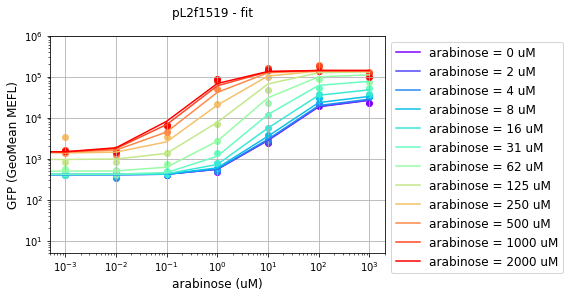

In [30]:
# Let's plot the fit, with GFP as a function of luxAHL, with constant arabinose

num_plots = len(pL2f1519_data.arabinose_uM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1519_data.arabinose_uM.unique():
    m = pL2f1519_data[pL2f1519_data.arabinose_uM == each]
    plt.plot(m.luxAHL_nM, inducible_activation_model(m.TF_MEFL, m.luxAHL_nM, *pL2f1519_parameters), 
             label = 'arabinose = ' + str(int(np.round(each))) + ' uM')
    plt.scatter(m.luxAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1519 - fit')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('arabinose (uM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1519 - GFP vs luxAHL - constant arabinose - fit.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

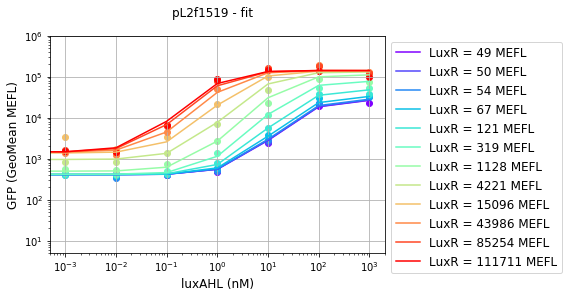

In [31]:
# Let's plot the fit, with GFP as a function of lasAHL, with constant LasR

num_plots = len(pL2f1519_data.TF_MEFL.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1519_data.TF_MEFL.unique():
    m = pL2f1519_data[pL2f1519_data.TF_MEFL == each]
    plt.plot(m.luxAHL_nM, inducible_activation_model(m.TF_MEFL, m.luxAHL_nM, *pL2f1519_parameters), 
             label = 'LuxR = ' + str(int(round(each))) + ' MEFL')
    plt.scatter(m.luxAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1519 - fit')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('luxAHL (nM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1519 - GFP vs luxAHL - constant luxR - fit.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

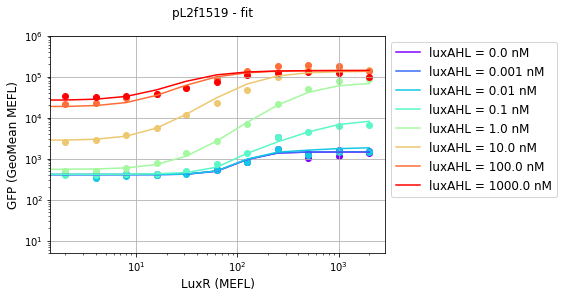

In [32]:
# Let's plot the fit, with GFP as a function of LasR, with constant lasAHL

num_plots = len(pL2f1519_data.luxAHL_nM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1519_data.luxAHL_nM.unique():
    m = pL2f1519_data[pL2f1519_data.luxAHL_nM == each]
    plt.plot(m.arabinose_uM, inducible_activation_model(m.TF_MEFL, m.luxAHL_nM, *pL2f1519_parameters),
             label = 'luxAHL = ' + str(each) + ' nM')
    plt.scatter(m.arabinose_uM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1519 - fit')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('LuxR (MEFL)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1519 - GFP vs LasR - constant luxAHL - fit.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

In [33]:
'''pL2f1525'''
print()

In [34]:
pL2f1525_data = pd.read_excel('pL2f1525.xlsx')
pL2f1525_data['TF_MEFL'] = pL2f1513_model(pL2f1517_data.arabinose_uM, *pL2f1513_fitted_parameters)
pL2f1525_data.head()

,arabinose_uM,luxAHL_nM,GFP,TF_MEFL
0,0.0,0.0,76.066744,48.878376
1,2.0,0.0,78.933024,50.044426
2,4.0,0.0,76.876623,53.500617
3,8.0,0.0,80.060595,67.199509
4,16.0,0.0,80.924705,121.474057


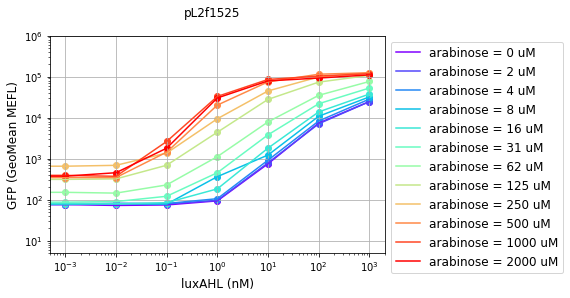

In [35]:
# Let's plot the raw data as a function of AHL, for constant arabinose

num_plots = len(pL2f1525_data.arabinose_uM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1525_data.arabinose_uM.unique():
    m = pL2f1525_data[pL2f1525_data.arabinose_uM == each]
    plt.plot(m.luxAHL_nM, m.GFP, label = 'arabinose = ' + str(int(np.round(each))) + ' uM')
    plt.scatter(m.luxAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1525')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('luxAHL (nM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1525 - GFP vs luxAHL - constant arabinose.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()


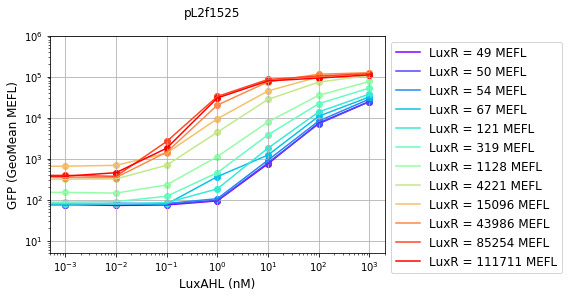

In [36]:
# Let's plot the raw data as a function of AHL, for constant transcription factor

num_plots = len(pL2f1525_data.TF_MEFL.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1525_data.TF_MEFL.unique():
    m = pL2f1525_data[pL2f1525_data.TF_MEFL == each]
    plt.plot(m.luxAHL_nM, m.GFP, label = 'LuxR = ' + str(int(np.round(each))) + ' MEFL')
    plt.scatter(m.luxAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1525')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('LuxAHL (nM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1525 - GFP vs luxAHL - constant LuxR.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()


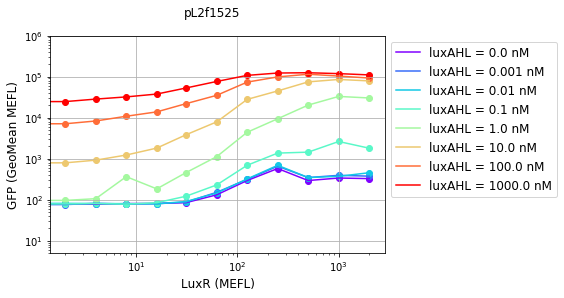

In [37]:
# Let's plot the raw data as a function of transcription factor, for constant AHL

num_plots = len(pL2f1525_data.luxAHL_nM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1525_data.luxAHL_nM.unique():
    m = pL2f1525_data[pL2f1525_data.luxAHL_nM == each]
    plt.plot(m.arabinose_uM, m.GFP, label = 'luxAHL = ' + str(each) + ' nM')
    plt.scatter(m.arabinose_uM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1525')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('LuxR (MEFL)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1525 - GFP vs LuxR - constant luxAHL.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()


In [38]:
def pL2f1525_error_function(current_parameter_guess):
    current_parameter_guess = tuple(current_parameter_guess)
    y_guess = inducible_activation_model(pL2f1525_data.TF_MEFL, pL2f1525_data.luxAHL_nM, *current_parameter_guess)
    error = np.log10(y_guess) - np.log10(pL2f1525_data.GFP)
    return error

initial_guess = (1, 1, 1, 1, 1, 1, 1, 1, 1)
low_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0]
up_bounds = [100000, 100000, 100000, 10, 100000, 10, 100000, 100000, 10]
pL2f1525_parameters = least_squares(pL2f1525_error_function,
                                    initial_guess, 
                                    bounds=(low_bounds, up_bounds)
                                    ).x
print(pL2f1525_parameters)

[  3.39655281e-01   1.32420653e+00   1.92798344e+03   2.22435710e+00
   3.28056118e+02   1.32165235e+00   4.75430955e+02   1.85849717e+02
   8.27921313e-01]


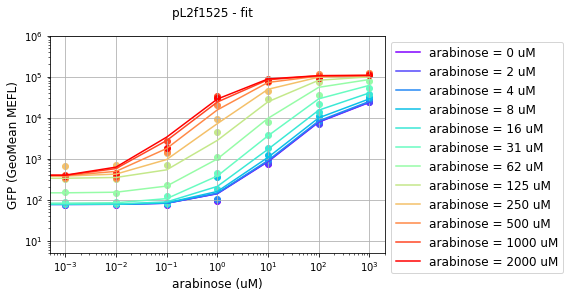

In [39]:
# Let's plot the fit, with GFP as a function of luxAHL, with constant arabinose

num_plots = len(pL2f1525_data.arabinose_uM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1525_data.arabinose_uM.unique():
    m = pL2f1525_data[pL2f1525_data.arabinose_uM == each]
    plt.plot(m.luxAHL_nM, inducible_activation_model(m.TF_MEFL, m.luxAHL_nM, *pL2f1525_parameters), 
             label = 'arabinose = ' + str(int(np.round(each))) + ' uM')
    plt.scatter(m.luxAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1525 - fit')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('arabinose (uM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1525 - GFP vs luxAHL - constant arabinose - fit.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

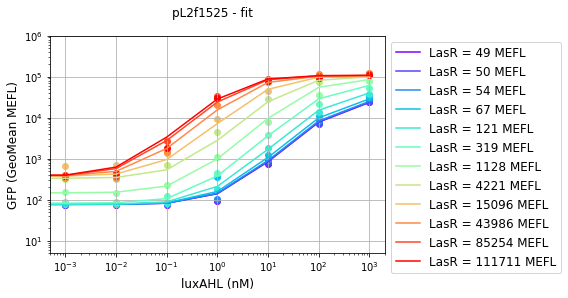

In [40]:
# Let's plot the fit, with GFP as a function of lasAHL, with constant LasR

num_plots = len(pL2f1525_data.TF_MEFL.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1519_data.TF_MEFL.unique():
    m = pL2f1525_data[pL2f1525_data.TF_MEFL == each]
    plt.plot(m.luxAHL_nM, inducible_activation_model(m.TF_MEFL, m.luxAHL_nM, *pL2f1525_parameters), 
             label = 'LasR = ' + str(int(round(each))) + ' MEFL')
    plt.scatter(m.luxAHL_nM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1525 - fit')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('luxAHL (nM)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1525 - GFP vs luxAHL - constant luxR - fit.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()

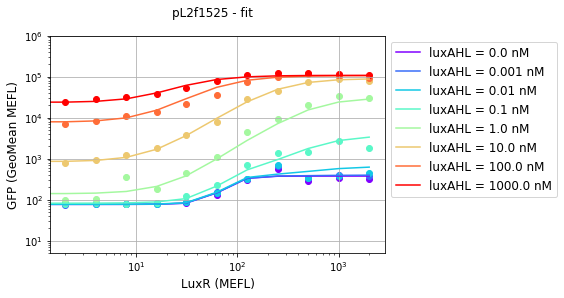

In [41]:
# Let's plot the fit, with GFP as a function of LasR, with constant lasAHL

num_plots = len(pL2f1525_data.luxAHL_nM.unique())
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, num_plots))))

for each in pL2f1525_data.luxAHL_nM.unique():
    m = pL2f1525_data[pL2f1525_data.luxAHL_nM == each]
    plt.plot(m.arabinose_uM, inducible_activation_model(m.TF_MEFL, m.luxAHL_nM, *pL2f1525_parameters),
             label = 'luxAHL = ' + str(each) + ' nM')
    plt.scatter(m.arabinose_uM, m.GFP, label = '_nolabel_')

plt.suptitle('pL2f1525 - fit')
plt.legend(bbox_to_anchor=(1,1), fontsize=12)

plt.xlabel('LuxR (MEFL)', fontsize=12)
plt.xscale('log')

plt.ylabel('GFP (GeoMean MEFL)', fontsize=12)
plt.yscale('log')
plt.ylim(custom_consistent_yaxis)

plt.grid()
plt.savefig('pL2f1525 - GFP vs LasR - constant luxAHL - fit.png', 
            transparent=True, bbox_inches='tight', dpi = 400, size=(8,6))
plt.show()